In [9]:
import numpy as np
import matplotlib.pyplot as plt
import methods 
import numpy.random as rand
from joblib import Parallel, delayed
import copy
import scipy.integrate
loc = "/Users/samuelbegg/Documents/NVC_squeezing/results/"

Define model

In [10]:
Jx = -1.0
Jy = -1.0
Jz = 3.8
hX = 0.0
hY = 0.0
hZ = 0.0
alpha = 1.5

# Simulation parameters
N = 50
total_samples = 10
samples = 10 #per batch
batches = int(total_samples / samples)
timesteps = 130
dt = 0.005 # save times 
num_cores = 12
plot_ED = "False"

# Generate interaction matrices
Jx_mat = Jx * methods.gen_matrices(N, alpha)
Jy_mat = Jy * methods.gen_matrices(N, alpha)
Jz_mat = Jz * methods.gen_matrices(N, alpha)
hX_mat = hX * np.ones(N)
hY_mat = hY * np.ones(N)
hZ_mat = hZ * np.ones(N)

# define for later use
timevec = dt * np.arange(0,timesteps+1)

Define initial state

In [11]:
# Classical position of spin 
S_init = np.zeros([N,3])
S_init[:,0] = 1.0     # X position
S_init[:,1] = 0.0     # Y position
S_init[:,2] = 0.0     # Z position



Perform integration of Monte Carlo samples

In [12]:
CorrZ_mean_batch = []
CorrY_mean_batch = []
CorrX_mean_batch = []
CorrYZ_mean_batch = []

CorrZ_std_batch = []
CorrY_std_batch = []
CorrX_std_batch = []
CorrYZ_std_batch = []

Sx_mean_batch = []
Sy_mean_batch = []
Sz_mean_batch = []
Sx_std_batch = []
Sy_std_batch = []
Sz_std_batch = []

Vmin_batch = []
Vmin_std_batch = []

for bb in range(0,batches):

    print(bb)

    Sx_samples = []
    Sy_samples = []
    Sz_samples = []

    np.random.seed(bb)
    # Create initial spin ensemble

    random_numbers = rand.randint(0,2,[samples, N, 3]) # generate random integers in range [0,1] for each sample and site in 3 directions (x,y,z)

    S_sample_init = np.zeros([samples,N,3])

    # draw random numbers for initial state if IC not aligned with axis 
    # (assumes translationally invariance)

    if S_init[0,0] == 0.0:

        S_sample_init[:,:,0] = 2 * (random_numbers[:,:,0] - 0.5 * np.ones([samples,N]))

    else:

        S_sample_init[:,:,0] = S_init[:,0] * np.ones([samples, N])

    if S_init[0,1] == 0.0:

        S_sample_init[:,:,1] = 2 * (random_numbers[:,:,1] - 0.5 * np.ones([samples,N]))

    else:
            
        S_sample_init[:,:,1] = S_init[:,1] * np.ones([samples, N])

    if S_init[0,2] == 0.0:

        S_sample_init[:,:,2] = 2 * (random_numbers[:,:,2] - 0.5 * np.ones([samples,N]))

    else:

        S_sample_init[:,:,2] = S_init[:,2] * np.ones([samples, N])

    #output = Parallel(n_jobs=num_cores)(delayed(methods.integration_Euler)(S_sample_init[ss,:,:], timesteps, dt, N, Jx_mat, Jy_mat, Jz_mat, h_mat) for ss in range(0,samples)) 

    output = Parallel(n_jobs=num_cores)(delayed(methods.integration_schemes)(S_sample_init[ss,:,:], timevec, N, Jx_mat, Jy_mat, Jz_mat, hX_mat, hY_mat, hZ_mat) for ss in range(0,samples)) 

    for ss in range(0,samples):
        Sx_samples = Sx_samples + [output[ss][0][:,:]]
        Sy_samples = Sy_samples + [output[ss][1][:,:]]
        Sz_samples = Sz_samples + [output[ss][2][:,:]]

    # Magnetization
    Sx_av = np.mean(Sx_samples,0)
    Sy_av = np.mean(Sy_samples,0)
    Sz_av= np.mean(Sz_samples,0)

    Sx_fluct = np.std(Sx_samples,0)
    Sy_fluct = np.std(Sy_samples,0) 
    Sz_fluct = np.std(Sz_samples,0)

    # Correlations

    # Compute all outer products for all samples and all time steps
    # Resulting shape: (samples, N, N, T)
    CorrZ_list  = np.einsum('snt,smt->snmt', Sz_samples, Sz_samples)
    CorrX_list  = np.einsum('snt,smt->snmt', Sx_samples, Sx_samples)
    CorrY_list  = np.einsum('snt,smt->snmt', Sy_samples, Sy_samples)
    CorrYZ_list = np.einsum('snt,smt->snmt', Sy_samples, Sz_samples)

    CorrZ_av = np.mean(CorrZ_list, 0)
    CorrX_av = np.mean(CorrX_list, 0)
    CorrY_av = np.mean(CorrY_list, 0)
    CorrYZ_av = np.mean(CorrYZ_list, 0)

    CorrZ_fluct = np.std(CorrZ_list, 0)
    CorrX_fluct = np.std(CorrX_list, 0)
    CorrY_fluct = np.std(CorrY_list, 0)
    CorrYZ_fluct = np.std(CorrYZ_list, 0)


    # Add to batch lists
    Sx_mean_batch += [Sx_av]
    Sy_mean_batch += [Sy_av]
    Sz_mean_batch += [Sz_av]
    Sx_std_batch += [Sx_fluct]
    Sy_std_batch += [Sy_fluct]
    Sz_std_batch += [Sz_fluct]

    CorrZ_mean_batch +=  [CorrZ_av] 
    CorrX_mean_batch += [CorrX_av] 
    CorrY_mean_batch += [CorrY_av] 
    CorrYZ_mean_batch += [CorrYZ_av] 

    CorrZ_std_batch += [CorrZ_fluct] 
    CorrX_std_batch += [CorrX_fluct] 
    CorrY_std_batch += [CorrY_fluct] 
    CorrYZ_std_batch += [CorrYZ_fluct] 


CorrZ_mean = np.mean(CorrZ_mean_batch,0)
CorrX_mean = np.mean(CorrX_mean_batch,0)
CorrY_mean = np.mean(CorrY_mean_batch,0)
CorrYZ_mean = np.mean(CorrYZ_mean_batch,0)

Sx_mean = np.mean(Sx_mean_batch,0)
Sy_mean = np.mean(Sy_mean_batch,0)
Sz_mean = np.mean(Sz_mean_batch,0)

Sx_std = np.std(Sx_mean_batch,0)
Sy_std = np.std(Sy_mean_batch,0)
Sz_std = np.std(Sz_mean_batch,0)

# Arbitrary angle correlator/variance
maxNu = 100

Vmin_mean = np.zeros(np.size(timevec))
Vmin_std = np.zeros(np.size(timevec))

nu_indices = np.arange(0,maxNu)
nu = 2 * np.pi * nu_indices / maxNu 

temp_VMin = np.einsum("u,st->ust", np.cos(nu)**2 , np.sum(np.sum(CorrY_mean_batch,1),1)) + np.einsum("u,st->ust", np.sin(nu)**2, np.sum(np.sum(CorrZ_mean_batch,1),1)) - np.einsum("u,st->ust", 2 * np.sin(nu) * np.cos(nu), np.sum(np.sum(CorrYZ_mean_batch,1),1)) 

for tt in range(0,np.size(timevec)):

    Vmin_nu = np.mean(temp_VMin[:,:,tt],1)
    Vmin_nu_std = np.std(temp_VMin[:,:,tt],1)
    arg = np.argmin(Vmin_nu)
    Vmin_mean[tt] = Vmin_nu[arg]
    Vmin_std[tt] = Vmin_nu_std[arg]


0


save data

In [13]:
np.save(loc + r"N="+str(N) + r"_samples=" +str(total_samples) + r"_dt="+str(dt)+ r"_Jz="+str(Jz)+"_Vmin.npy",Vmin_mean)
np.save(loc + r"N="+str(N) + r"_samples=" +str(total_samples) + r"_dt="+str(dt)+ r"_Jz="+str(Jz)+"_Vmin_std.npy",Vmin_std)
np.save(loc + r"N="+str(N) + r"_samples=" +str(total_samples) + r"_dt="+str(dt)+ r"_Jz="+str(Jz)+"_Sy.npy",Sy_mean)
np.save(loc + r"N="+str(N) + r"_samples=" +str(total_samples) + r"_dt="+str(dt)+ r"_Jz="+str(Jz)+"_Sx.npy",Sx_mean)
np.save(loc + r"N="+str(N) + r"_samples=" +str(total_samples) + r"_dt="+str(dt)+ r"_Jz="+str(Jz)+"_Sz.npy",Sz_mean)
np.save(loc + r"N="+str(N) + r"_samples=" +str(total_samples) + r"_dt="+str(dt)+ r"_Jz="+str(Jz)+"_SySz.npy",np.sum(np.sum(CorrYZ_mean,0),0))
np.save(loc + r"N="+str(N) + r"_samples=" +str(total_samples) + r"_dt="+str(dt)+ r"_Jz="+str(Jz)+"_SySy.npy",np.sum(np.sum(CorrY_mean,0),0))
np.save(loc + r"N="+str(N) + r"_samples=" +str(total_samples) + r"_dt="+str(dt)+ r"_Jz="+str(Jz)+"_SxSx.npy",np.sum(np.sum(CorrX_mean,0),0))
np.save(loc + r"N="+str(N) + r"_samples=" +str(total_samples) + r"_dt="+str(dt)+ r"_Jz="+str(Jz)+"_timevec.npy",timevec)

plot results

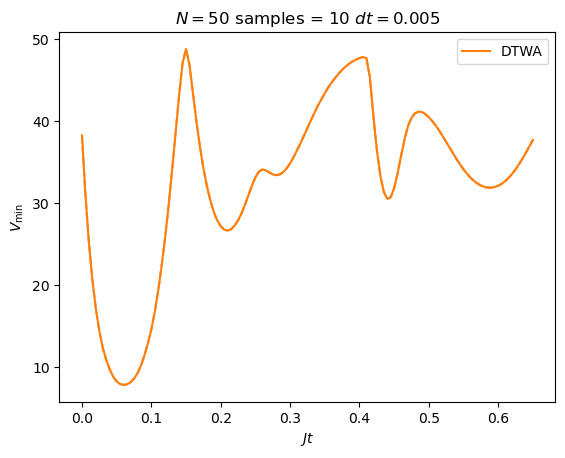

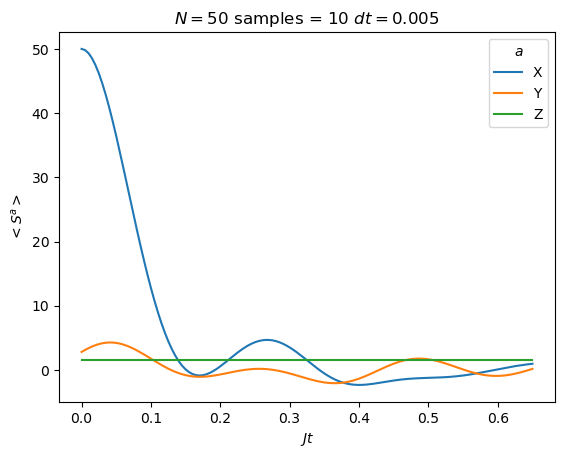

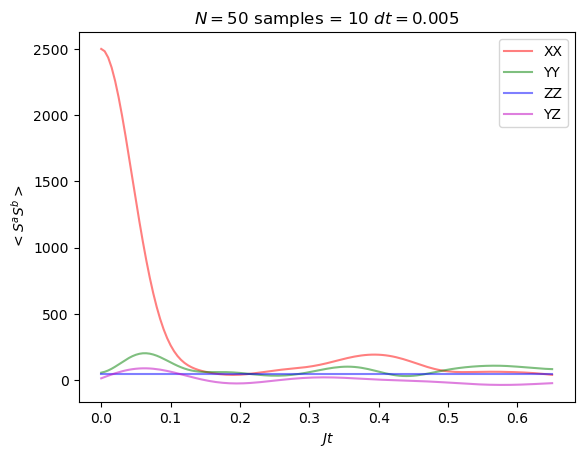

In [15]:
plt.plot(timevec,Vmin_mean,label = "DTWA",color = "tab:orange")
plt.plot(timevec,Vmin_mean + Vmin_std / np.sqrt(batches),"--",color = "tab:orange",alpha = 0.5)
plt.plot(timevec,Vmin_mean - Vmin_std / np.sqrt(batches),"--",color = "tab:orange",alpha = 0.5)

plt.xlabel(r"$Jt$")
plt.ylabel(r"$V_{\rm min}$")
plt.legend()
plt.title(r"$N=$"+str(N) + r" samples = " +str(total_samples) + r" $dt = $"+str(dt))
plt.show()

# Check signal length Sx
plt.plot(timevec, np.sum(Sx_mean,0), label= "X")
plt.plot(timevec, np.sum(Sy_mean,0),label= "Y")
plt.plot(timevec, np.sum(Sz_mean,0),label= "Z")
plt.legend()
plt.xlabel(r"$Jt$")
plt.ylabel(r"$<S^a>$")
plt.title(r"$N=$"+str(N) + r" samples = " +str(total_samples) + r" $dt = $"+str(dt))
plt.legend(title = r"$a$")
plt.show()


# Check X, Y , Z correlators
plt.plot(timevec, np.sum(np.sum(CorrX_mean,0),0),"r",label= "XX",alpha = 0.5)
plt.plot(timevec, np.sum(np.sum(CorrY_mean,0),0),"g",label= "YY",alpha = 0.5)
plt.plot(timevec, np.sum(np.sum(CorrZ_mean,0),0),"b",label= "ZZ",alpha = 0.5)
plt.plot(timevec, np.sum(np.sum(CorrYZ_mean,0),0),"m",label= "YZ",alpha = 0.5)

plt.xlabel(r"$Jt$")
plt.ylabel(r"$<S^aS^b>$")
plt.title(r"$N=$"+str(N) + r" samples = " +str(total_samples) + r" $dt = $"+str(dt))
plt.legend()
plt.show() 

